In [1]:
from pflow.particle_filter import BootstrapFilter, ObservationBase, FilterState, LikelihoodMethodBase, ProposalMethodBase
from pflow.base import BaseReweight
from pflow.optimal_transport.transportation_plan import Transport
from pflow.resampling.systematic import SystematicResampling
from pflow.optimal_transport.recentering import LearnBest, IncrementalLearning
from joblib import Parallel, delayed


In [2]:
import pykalman
import numpy as np
import torch
import tqdm
import matplotlib.pyplot as plt

%matplotlib inline

### SSM defintion

In [3]:
class ProposalMethod(ProposalMethodBase):
    def __init__(self, bias, state_size):
        locs = torch.zeros(state_size, requires_grad=False) + bias
        self._dist = torch.distributions.MultivariateNormal(locs, scale_tril=torch.eye(state_size))
        
    def apply(self, state, _observation):
        x = state.x
        sample = self._dist.rsample((x.shape[0],))
        x_proposed =  0.5 * x + sample
        return FilterState(x=x_proposed, logw=state.logw, n=state.n, loglik=state.loglik)
    
class Observation(ObservationBase):
    __slots__ = ['y']
    def __init__(self, y):
        self.y = y
        
class LikelihoodMethod(LikelihoodMethodBase):
    def __init__(self, obs_matrix):
        locs = torch.zeros(obs_matrix.shape[0], requires_grad=False)
        self._obs_matrix = obs_matrix
        self._dist = torch.distributions.MultivariateNormal(loc=locs, 
                                                            scale_tril=torch.eye(observation_matrix.shape[0]))
        
    def apply(self, state, observation, log=True):
        distance = (self._obs_matrix @ state.x.T).T - observation.y.unsqueeze(0)
        log_probs = self._dist.log_prob(distance)
        if log:
            return log_probs
        else:
            return log_probs.exp()
        
class NoResampling(BaseReweight):
    def apply(self, x, w, logw):
        return x, logw

In [4]:
_ = torch.random.manual_seed(0)

In [5]:
import math
import random
random.seed(42)

In [6]:
def autoregressive(transition_matrix, observation_matrix, seed=42):
    np.random.seed(seed)
    x = np.zeros(transition_matrix.shape[1])
    yield (observation_matrix @ x).squeeze() + np.random.randn(observation_matrix.shape[0])
    while True:
        x = (transition_matrix @ x).squeeze() + np.random.randn(x.shape[0])
        yield (observation_matrix @ x).squeeze() + np.random.randn(observation_matrix.shape[0])
    

In [7]:
# 1D

In [8]:
def ar_pf(values, 
          lamda, 
          observation_matrix,
          epsilon=0.5, 
          n=100, 
          seed=1234, 
          scaling=0.75, 
          reach=None, 
          min_neff=0.5, 
          resampling_method=None):
    states = []
    observations = []
    
    torch.random.manual_seed(seed)
    
    initial_x = torch.zeros((n, observation_matrix.shape[1]))
    initial_x.requires_grad=False
    torch_observation = torch.tensor(observation_matrix.astype(np.float32))
    initial_w = torch.full((n,), 1/n, requires_grad=True)
    initial_log_lik = torch.tensor(0., requires_grad=True)
    
    state = FilterState(x=initial_x, logw=initial_w.log(), n=n, loglik=initial_log_lik)
    
    likelihood_method = LikelihoodMethod(torch_observation)
    
    if resampling_method is None:
        if epsilon > 0:
            resampling_method = Transport(epsilon=epsilon, scaling=scaling, reach=reach)
        else:
            resampling_method = SystematicResampling()
    boot = BootstrapFilter(proposal_method=ProposalMethod(lamda, observation_matrix.shape[1]),
                           likelihood_method=likelihood_method, 
                           reweighting_method=resampling_method,
                           min_neff=min_neff)
    n_obs = 0
    for val in values:
        n_obs += 1
        obs = Observation(torch.tensor(val, requires_grad=False))
        state = boot.update(state, obs)
        observations.append(obs)
        states.append(state)
        
        state = boot.predict(state, None)
    return -state.loglik / n_obs, states, observations

In [9]:
linspace = np.linspace(-1., 1., 300)
n_experiments = 1


In [10]:
T = 150
transition_matrix = np.array([[0.5]])
observation_matrix = np.array([[1.]])
observations_lists = []
for i in range(2):
    autoregressive_gen = autoregressive(transition_matrix, observation_matrix, seed=i)
    ar = [next(autoregressive_gen) for _ in range(T)]
    observations_lists.append(np.asanyarray(ar[:]).astype(np.float32))


In [11]:
##### from transport

learnt_resampling_method = LearnBest(0.25, {'scaling': 0.25}, learning_rate=1., optimizer_kwargs={}, 
                                     schedule_kwargs={'gamma': 1., 'step_size':1}, n_steps=3, 
                                     start_from_regularised=True, jitter=0.01, 
                                     optim_class_name='SGD',
                                     scheduler_class_name='StepLR')
lamda_tensor = torch.tensor(0.7, requires_grad=True)
res = ar_pf(observations_lists[0], lamda_tensor, observation_matrix, None, n=25, min_neff=0.5, seed=3, resampling_method=learnt_resampling_method)
print(res[0])
print(torch.autograd.grad( res[0], lamda_tensor ))

tensor(2.1019, grad_fn=<DivBackward0>)
(tensor(0.2274),)


In [12]:
##### from transport
learnt_resampling_method = LearnBest(0.75, {'scaling': 0.25}, learning_rate=1., optimizer_kwargs={}, 
                                     schedule_kwargs={'gamma': 1., 'step_size':1}, n_steps=3, 
                                     start_from_regularised=True, jitter=0.01, 
                                     optim_class_name='SGD',
                                     scheduler_class_name='StepLR')
lamda_tensor = torch.tensor(0.7, requires_grad=True)
res = ar_pf(observations_lists[0], lamda_tensor, observation_matrix, None, n=25, min_neff=0.5, seed=3, resampling_method=learnt_resampling_method)
print(res[0])
print(torch.autograd.grad( res[0], lamda_tensor ))

tensor(2.1055, grad_fn=<DivBackward0>)
(tensor(0.2431),)


In [13]:
##### from systematic
learnt_resampling_method = LearnBest(0.1, {'scaling': 0.25}, learning_rate=1., optimizer_kwargs={}, 
                                     schedule_kwargs={'gamma': 1., 'step_size':1}, n_steps=3, 
                                     start_from_regularised=False, start_from_systematic=True, jitter=0.1, 
                                     optim_class_name='SGD',
                                     scheduler_class_name='StepLR')
lamda_tensor = torch.tensor(0.7, requires_grad=True)
res = ar_pf(observations_lists[0], lamda_tensor, observation_matrix, None, n=25, min_neff=0.5, seed=0, resampling_method=learnt_resampling_method)
print(res[0])
print(torch.autograd.grad(res[0], lamda_tensor))

tensor(2.0664, grad_fn=<DivBackward0>)
(tensor(0.2617),)


In [14]:
# Direct
lamda_tensor = torch.tensor(0.7, requires_grad=True)
res = ar_pf(observations_lists[0], lamda_tensor, observation_matrix, 0.5, n=25, min_neff=0.5, seed=0)
print(res[0])
print(torch.autograd.grad(res[0], lamda_tensor))


tensor(2.0827, grad_fn=<DivBackward0>)
(tensor(0.5037),)


In [15]:
# KF
kf = pykalman.KalmanFilter(observation_covariance=[[1.]], 
                       transition_covariance=[[1.]], 
                       transition_matrices=[[0.5]], 
                       transition_offsets=[0.7], 
                       initial_state_mean=[0.],
                       initial_state_covariance=[[0.]])
kf_eps = pykalman.KalmanFilter(observation_covariance=[[1.]], 
                               transition_covariance=[[1.]], 
                               transition_matrices=[[0.5]], 
                               transition_offsets=[0.7 + 1e-4],
                               initial_state_mean=[0.],
                               initial_state_covariance=[[0.]])
ll = kf.loglikelihood(observations_lists[0])
ll_eps = kf_eps.loglikelihood(observations_lists[0])
print(-ll / T)
print(1e4*(ll / T - ll_eps / T))

1.97497393902311
0.507508341149876


In [16]:
N = 25

In [17]:
gradients_for_systematic = {}
ll_for_systematic = {}
for n in [N]:
    gradients = []
    likelihoods = []
    for data in tqdm.tqdm(observations_lists):
        gradients_data = []
        likelihoods_data = []
        for value in linspace:
            lamda_tensor = torch.tensor(value, requires_grad=True)
            gradient_for_seed = []
            likelihood_for_seed = []
            for i in range(n_experiments):
                res = ar_pf(data, lamda_tensor, observation_matrix, 0., n=n, min_neff=0.5, seed=12345 + i)
                likelihood_for_seed.append(-res[0].detach().cpu().numpy().sum()*T)
                grad = torch.autograd.grad(-res[0] * T, lamda_tensor)[0].detach().cpu().numpy()
                gradient_for_seed.append(grad.sum())
            gradients_data.append(gradient_for_seed)
            likelihoods_data.append(likelihood_for_seed)
        likelihoods.append(likelihoods_data)
        gradients.append(gradients_data)
    gradients_for_systematic[n] = gradients
    ll_for_systematic[n] = likelihoods

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:50<00:00, 56.10s/it]


In [18]:
gradients_for_transport = {}
ll_for_transport = {}
for eps in [0.25, 0.5, 0.75]:
    gradients = []
    likelihoods = []
    for data in tqdm.tqdm(observations_lists):
        gradients_data = []
        likelihoods_data = []
        for value in linspace:
            lamda_tensor = torch.tensor(value, requires_grad=True)
            gradient_for_seed = []
            likelihood_for_seed = []
            for i in range(n_experiments):
                res = ar_pf(data, lamda_tensor, observation_matrix, eps, scaling=0.5, n=N, min_neff=0.5, seed=12345 + i)
                likelihood_for_seed.append(-res[0].detach().cpu().numpy().sum()*T)
                grad = torch.autograd.grad(-res[0] * T, lamda_tensor)[0].detach().cpu().numpy()
                gradient_for_seed.append(grad.sum())
            gradients_data.append(gradient_for_seed)
            likelihoods_data.append(likelihood_for_seed)
        likelihoods.append(likelihoods_data)
        gradients.append(gradients_data)
    gradients_for_transport[eps] = gradients
    ll_for_transport[eps] = likelihoods

100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [05:14<00:00, 158.09s/it]


In [20]:
gradients_for_learnt = {}
ll_for_learnt = {}
for start_from_systematic, start_from_regularised in [[True, False], [False, True]]:
    gradients = []
    likelihoods = []
    for data in tqdm.tqdm(observations_lists):
        gradients_data = []
        likelihoods_data = []
        for value in linspace:
            lamda_tensor = torch.tensor(value, requires_grad=True)
            gradient_for_seed = []
            likelihood_for_seed = []
            for i in range(n_experiments):
                learnt_resampling_method = LearnBest(0.1, {'scaling': 0.5}, learning_rate=1., optimizer_kwargs={}, 
                                                     schedule_kwargs={'gamma': 0.9, 'step_size':1}, n_steps=5, 
                                                     start_from_regularised=start_from_regularised, start_from_systematic=start_from_systematic, 
                                                     jitter=0., 
                                                     optim_class_name='SGD',
                                                     scheduler_class_name='StepLR')
                res = ar_pf(data, lamda_tensor, observation_matrix, None, scaling=None, n=15, min_neff=0.5, seed=12345 + i, resampling_method=learnt_resampling_method)
                likelihood_for_seed.append(-res[0].detach().cpu().numpy().sum()*T)
                grad = torch.autograd.grad(-res[0] * T, lamda_tensor)[0].detach().cpu().numpy()
                gradient_for_seed.append(grad.sum())
            gradients_data.append(gradient_for_seed)
            likelihoods_data.append(likelihood_for_seed)
        likelihoods.append(likelihoods_data)
        gradients.append(gradients_data)
    gradients_for_learnt[(start_from_systematic, start_from_regularised)] = gradients
    ll_for_learnt[(start_from_systematic, start_from_regularised)] = likelihoods


100%|██████████████████████████████████████████████████████████████████████████████████| 2/2 [37:00<00:00, 1124.37s/it]

In [21]:
ll_for_kalman = []
grads_for_kalman = []

for data in tqdm.tqdm(observations_lists):
    gradients_data = []
    likelihoods_data = []
    for value in linspace:
        kf = pykalman.KalmanFilter(observation_covariance=[[1.]], 
                               transition_covariance=[[1.]], 
                               transition_matrices=[[0.5]], 
                               transition_offsets=[value], 
                               initial_state_mean=[0.],
                               initial_state_covariance=[[0.]])
        kf_eps = pykalman.KalmanFilter(observation_covariance=[[1.]], 
                                       transition_covariance=[[1.]], 
                                       transition_matrices=[[0.5]], 
                                       transition_offsets=[value + 1e-4],
                                       initial_state_mean=[0.],
                                       initial_state_covariance=[[0.]])
        ll = kf.loglikelihood(data)
        ll_eps = kf_eps.loglikelihood(data)
        likelihoods_data.append(ll)
        gradients_data.append(1e4*(ll_eps-ll))
    ll_for_kalman.append(likelihoods_data)    
    grads_for_kalman.append(gradients_data)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:33<00:00, 46.98s/it]

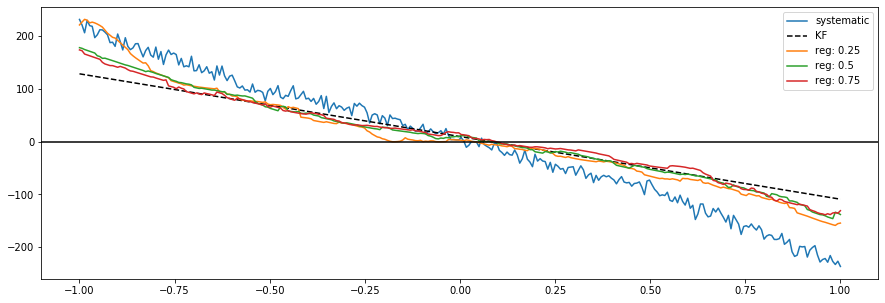

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5), sharex=True, sharey=True)
# for i, ax in enumerate(axes.flatten()):
systematic_grad = gradients_for_systematic[N][0]
ax.plot(linspace, np.mean(systematic_grad, 1), label = 'systematic')    
ax.plot(linspace, grads_for_kalman[1], label = 'KF', color = 'k', linestyle='--')    
for eps, transport_gradients in gradients_for_transport.items():
    ax.plot(linspace, np.mean(transport_gradients[0], 1), label = 'reg: {}'.format(eps))    
#     for (start_from_systematic, start_from_regularised), learnt_gradients in gradients_for_learnt.items():
#         label = 'from systematic' if start_from_systematic else 'from regularised'
#         ax.plot(linspace, np.mean(learnt_gradients[i], 1), label = label)

ax.axhline(0, linestyle='-', color='k')
_ = ax.legend()

fig.savefig('gradBleiExample.png')


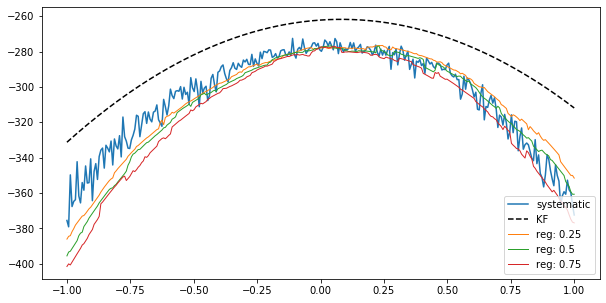

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5), sharex=True, sharey=False)
systematic_ll = ll_for_systematic[N][0]
ax.plot(linspace, np.mean(systematic_ll, 1), label = 'systematic')    
ax.plot(linspace, ll_for_kalman[i], label = 'KF', color = 'k', linestyle='--')    

for eps, ll_transport in ll_for_transport.items():
    ax.plot(linspace, np.mean(ll_transport[0], 1), label = 'reg: {}'.format(eps), linewidth  = 1)    
#     for (start_from_systematic, start_from_regularised), learnt_ll in ll_for_learnt.items():
#         label = 'from systematic' if start_from_systematic else 'from regularised'
#         ax.plot(linspace, np.mean(learnt_ll[i], 1), label = label)

_ = ax.legend(loc='lower right')
fig.savefig('llCompBlei.png')

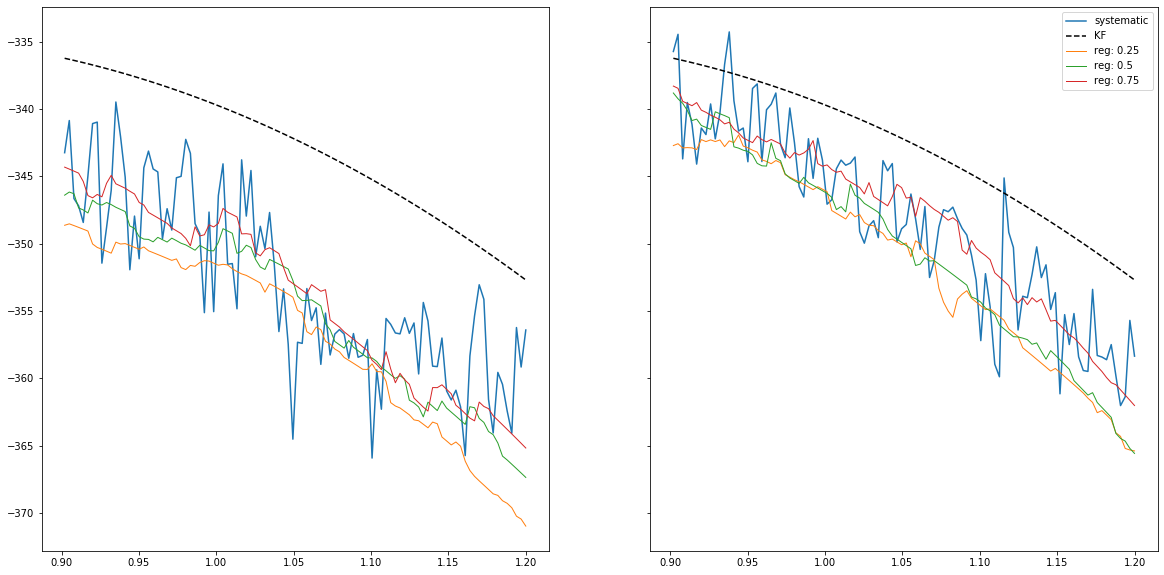

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10), sharex=True, sharey=True)
sub_slice = slice(200, 300)
for i, ax in enumerate(axes.flatten()):
    systematic_ll = ll_for_systematic[15][i]
    ax.plot(linspace[sub_slice], np.mean(systematic_ll, 1)[sub_slice], label = 'systematic')    
    ax.plot(linspace[sub_slice], ll_for_kalman[1][sub_slice], label = 'KF', color = 'k', linestyle='--')    

    for eps, ll_transport in ll_for_transport.items():
        ax.plot(linspace[sub_slice], np.mean(ll_transport[i], 1)[sub_slice], label = 'reg: {}'.format(eps), linewidth  = 1)    

_ = ax.legend()

### Let's learn

In [ ]:
n_iter = 20
lr = 1.
lamda_tensor = torch.tensor(0., requires_grad=True)
lambda_values_sys = [0.]
autoregressive_gen = autoregressive(transition_matrix, observation_matrix, seed=5)

for _ in tqdm.trange(n_iter):
    data = observations_lists[0]
    
    temp_res = ar_pf(data, lamda_tensor, observation_matrix, 0., n=10, min_neff=0.5)
    grad = torch.autograd.grad(temp_res[0], lamda_tensor)
    lamda_tensor.data -= lr * grad[0]
    lambda_values_sys.append(lamda_tensor.detach().cpu().numpy().sum())


In [ ]:
n_iter = 20
lr = 1.
lamda_tensor = torch.tensor(0., requires_grad=True)
lambda_values_transport = [0.]
autoregressive_gen = autoregressive(transition_matrix, observation_matrix, seed=5)

for _ in tqdm.trange(n_iter):
    ar = [next(autoregressive_gen) for _ in range(200)]
    data = observations_lists[0]
    
    temp_res = ar_pf(data, lamda_tensor, observation_matrix, 0.5, scaling=0.5, n=10, min_neff=0.5, seed=666)
    grad = torch.autograd.grad(temp_res[0], lamda_tensor)
    lamda_tensor.data -= lr * grad[0]
    lambda_values_transport.append(lamda_tensor.detach().cpu().numpy().sum())


In [ ]:
plt.plot(lambda_values_sys)

In [ ]:
plt.plot(lambda_values_transport)

In [ ]:
n_iter = 20
lr = 0.01
lamda_val = 0.
lamda_val_list = [lamda_val]
autoregressive_gen = autoregressive(transition_matrix, observation_matrix, seed=1)

for _ in tqdm.trange(n_iter):
    ar = [next(autoregressive_gen) for _ in range(200)]
    data = observations_lists[0]
    
    kf = pykalman.KalmanFilter(observation_covariance=[[1.]], 
                               transition_covariance=[[1.]], 
                               transition_matrices=[[0.5]], 
                               transition_offsets=[lamda_val], 
                               initial_state_mean=[0.],
                               initial_state_covariance=[[0.]])
    
    kf_eps = pykalman.KalmanFilter(observation_covariance=[[1.]], 
                                  transition_covariance=[[1.]], 
                                   transition_matrices=[[0.5]], 
                                   transition_offsets=[lamda_val + 1e-6],
                                   initial_state_mean=[0.],
                                   initial_state_covariance=[[0.]])
    
    ll = -kf.loglikelihood(data)
    ll_eps = -kf_eps.loglikelihood(data)
    grad = (ll_eps - ll) * 1e6
    lamda_val -= lr * grad
    lamda_val_list.append(lamda_val)



In [ ]:
plt.plot(lamda_val_list)

In [ ]:
plt.plot(phi_tensors_ot, label = 'learn OT')
plt.plot(phi_tensors_sys, label = 'learn Sys')
plt.plot(phi_tensors_kf, label = 'learn KF')
plt.legend()

In [ ]:
alpha = 0.42
d = 10
transition_matrix = np.asarray([[alpha ** (abs(i-j) + 1) for j in range(1, d+1)] for i in range(1, d+1)])

In [ ]:
n_obs = 1
sparse_observation = np.eye(n_obs, d, dtype=float)

In [ ]:
def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights, axis=0)
    # Fast and numerically precise:
    variance = np.average((values-average)**2, weights=weights, axis=0)
    return (average, np.sqrt(variance))

In [ ]:
def plot_pf_component(pf_res, linspace, component, ax, label, show=None):
    pf_state, pf_weight = zip(*[(l.x.detach().cpu().numpy(),  l.w.detach().cpu().numpy()) for l in pf_res[1]])
    pf_weight = np.stack(pf_weight, axis=0)
    pf_state = np.stack(pf_state, axis=0)

    pf_mean, pf_std = weighted_avg_and_std(pf_state[:, :, component].T,  pf_weight.T)
    ax.plot(linspace[: show], pf_mean[: show], label = label)
    ax.fill_between(linspace[: show], 
                    pf_mean[: show] - 2 * pf_std[: show],
                    pf_mean[: show] + 2 * pf_std[: show], alpha = 0.3)
    

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 5), sharex=True, sharey=True)

show = 100
linspace = np.arange(0, T)

axes[0, 0].plot(linspace[: show], ar_kf[0][:, 0].squeeze()[: show], label='Kalman Filter')
axes[0, 0].fill_between(linspace[: show], 
                     ar_kf[0][:, 0].squeeze()[: show] - 2*np.sqrt(ar_kf[1][:, 0, 0])[: show],
                     ar_kf[0][:, 0].squeeze()[: show] + 2*np.sqrt(ar_kf[1][:, 0, 0])[: show], alpha = 0.3)


plot_pf_component(ar_10, linspace, 0, axes[1, 0], 'particle filter, eps = 0.1', show)
plot_pf_component(ar_100, linspace, 0, axes[1, 1], 'particle filter, eps = 1.00', show)
plot_pf_component(ar_systematic, linspace, 0, axes[0, 1], 'particle filter, systematic', show)


for ax in axes.flatten():
    ax.legend(loc='upper right')

# axes[0].set_title('AR(1)')

# fig.savefig('AR_PF_optimalTransport.png')

In [ ]:
linspace = np.linspace(0.25, 0.75, 250)
epsilons = [0.1, 0.15, 0.2, 0.25, 0.3, 0.5, 0.75, 1.]

In [ ]:
results_for_smoothness_ot_dict = {}
results_for_smoothness_ot_grad_dict = {}
for eps in epsilons:
    results_for_smoothness_ot_dict[eps] = []
    results_for_smoothness_ot_grad_dict[eps] = []
    for val in tqdm.tqdm(linspace):
        phi_tensor = torch.tensor(val, requires_grad=True)
        temp_res = ar_pf(observations, phi_tensor, log_noise, log_error, eps, n=100, scaling=0.9, min_neff=0.5, reach=None)
#         temp_res = run_pf(flat, log_sigma_val, dt_tensor, eps, n=100, scaling=0.9, min_neff=0.5, reach=5.)
        results_for_smoothness_ot_grad_dict[eps].append(torch.autograd.grad(temp_res[0], phi_tensor)[0].detach().cpu().numpy())
        results_for_smoothness_ot_dict[eps].append(temp_res[0].detach().cpu().numpy())
    


In [ ]:
results_for_smoothness_systematic_dict = {}
results_for_smoothness_systematic_grad_dict = {}
for n in [100]:
    results_for_smoothness_systematic_dict[n] = []
    results_for_smoothness_systematic_grad_dict[n] = []
    for val in tqdm.tqdm(linspace):
        phi_tensor = torch.tensor(val, requires_grad=True)
        temp_res = ar_pf(observations, phi_tensor, log_noise, log_error, 0., n=100, min_neff=0.5)
        results_for_smoothness_systematic_grad_dict[n].append(torch.autograd.grad(temp_res[0], phi_tensor)[0].detach().cpu().numpy())
        results_for_smoothness_systematic_dict[n].append(temp_res[0].detach().cpu().numpy())


In [ ]:
# results_for_learnt_ot_dict = {}
# eps = 0.1
# adam_kwargs = {'lr': 0.5}
# methods = {#'incremental': IncrementalLearning(eps, {'scaling': 0.5}, adam_kwargs, 4, 5),
#            'one-shot': LearnBest(eps, {'scaling': 0.75}, adam_kwargs, 10)}
# for name, method in methods.items():
#     results_for_learnt_ot_dict[name] = [~]
#     for val in tqdm.tqdm(linspace):
#         log_sigma_tensor = torch.tensor(val, requires_grad=False)
#         temp_res = run_pf(flat, log_sigma_tensor, dt_tensor, eps, n=250, reweighting_method=method)
#         results_for_learnt_ot_dict[name].append(temp_res[0].detach().cpu().numpy())


In [ ]:
results_for_kalman = []
grads_for_kalman = []
for val in tqdm.tqdm(linspace):
    kf = pykalman.KalmanFilter(observation_covariance=[[0.01]], 
                               transition_covariance=[[0.01]], 
                               transition_matrices=[[val]], 
                               initial_state_mean=[0.])
    kf_eps = pykalman.KalmanFilter(observation_covariance=[[0.01]], 
                                   transition_covariance=[[0.01]], 
                                   transition_matrices=[[val + 1e-4]], 
                                   initial_state_mean=[0.])
    ll = -kf.loglikelihood(observations)/len(observations)
    ll_eps = -kf_eps.loglikelihood(observations)/len(observations)
    results_for_kalman.append(ll)
    grads_for_kalman.append(1e4*(ll_eps-ll))

In [ ]:
def plot_gradient(linspace, values, gradients, k, ax, line):
    x = np.take(linspace, k)
    y = np.take(values, k)
    v = np.take(gradients, k)
    u = [1]*len(k)
    ax.quiver(x, y, u, v, scale=20, zorder=3, color=l.get_color(),
          width=0.007, headwidth=3., headlength=4.)

In [ ]:
fig, ax = plt.subplots(ncols=1, figsize=(15, 4), sharey=False, sharex=False)
fig.suptitle('Likelihood function comparison', y = 1.01)

for eps, lst in results_for_smoothness_ot_dict.items():
    if eps >= 0.25:
        arr = np.asanyarray(lst)
        ax.plot(linspace, arr - arr.min(), label=f'Biased OT: eps={eps}')
arr_sys = np.asanyarray(results_for_smoothness_systematic_dict[100])
ax.plot(linspace, arr_sys - arr_sys.min(), label=f'Systematic resampling', alpha=0.5)

arr_kf = np.asanyarray(results_for_kalman)
ax.plot(linspace, arr_kf - arr_kf.min(), label = 'Kalman filter', linestyle = '--')

# zoom = slice(0, 250)
# grads_locs =  [25, 100, 175]
# for eps, lst in results_for_smoothness_ot_dict.items():
#     l, = axes[1].plot(linspace[zoom], lst[zoom], label=f'Biased OT: eps={eps}')
#     plot_gradient(linspace, lst, results_for_smoothness_ot_grad_dict[eps], grads_locs, axes[1], l)

# l, = axes[1].plot(linspace[zoom], results_for_smoothness_systematic_dict[100][zoom], label=f'Systematic resampling', alpha=0.5)
# plot_gradient(linspace, results_for_smoothness_systematic_dict[100], results_for_smoothness_systematic_grad_dict[100], grads_locs, axes[1], l)

# axes[1].plot(linspace[zoom], results_for_kalman[zoom], label = 'Kalman filter', linestyle = '--')

# for ax in axes.flatten():
ax.set_ylabel('$\\frac{-loglik}{n_{samples}}$', rotation=0, y=1, fontsize=15)
ax.set_xlabel('$\phi$', rotation=0, y=1, fontsize=15)
    
ax.legend()
    
fig.savefig('ar_likelihood.png')

In [ ]:
fig, ax = plt.subplots(figsize=(15, 4), sharey=False, sharex=True)
fig.suptitle('Likelihood function gradient comparison', y = 1.01)
for eps, grads in results_for_smoothness_ot_grad_dict.items():
    if eps >= 0.25:
        ax.plot(linspace, np.stack(grads), label = f'Biased OT: eps={eps}')
    
ax.plot(linspace, np.stack(results_for_smoothness_systematic_grad_dict[100]), label='Systematic Resampling')
ax.plot(linspace, np.stack(grads_for_kalman), label='KF', linestyle='--')

ax.legend()
fig.savefig('ar_likelihoodGradient.png')

In [ ]:
fig, ax = plt.subplots(figsize=(15, 4), sharey=False, sharex=True)
fig.suptitle('Antiderivative (cumsum) gradient comparison', y = 1.01)
for eps, grads in results_for_smoothness_ot_grad_dict.items():
    if eps >= 0.25:
        ax.plot(linspace, np.cumsum(np.stack(grads)), label = f'Biased OT: eps={eps}')
    
ax.plot(linspace, np.cumsum(np.stack(results_for_smoothness_systematic_grad_dict[100])), label='Systematic Resampling')
ax.plot(linspace, np.cumsum(np.stack(grads_for_kalman)), label='KF', linestyle='--')

ax.legend()
fig.savefig('ar_likelihoodGradient.png')